In [128]:
from net import skip
from net.losses import ExclusionLoss, plot_image_grid, StdLoss, CannyDiceLoss, HistogramLoss
from net.noise import get_noise
from utils.image_io import *
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from collections import namedtuple
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [137]:
class PreTrain(object):
    def __init__(self, dataset, save_path, num_iter=25):
        self.dataset = dataset

        self.num_iter = num_iter

        self.psnrs = []

        self.loss_function = None

        self.parameters = None
        self.learning_rate = 0.001
        # self.learning_rate = 0.01
        self.input_depth = 3

        self.net_inputs = None

        self.net = None

        self.total_loss = None
        self.out = None

        self.current_result = None
        self.best_result = None

        self.train_loader = None
        self.test_loader = None

        self.optimizer = None

        self.save_path = save_path
        self.loss_curve = []
        self.test_results = []
        self.test_losses = []

        self.ssim_loss = None

        self.fig = None
        self.axs = None

        torch.manual_seed(42)

        self._init_all()

    def _init_all(self):
        self._init_nets()
        self._init_dataset()
        self._init_parameters()
        self._init_losses()

    def _init_plot(self, n=3):
        self.fig, self.axs = plt.subplots(1, n, figsize=(5*n, 5))
        if n == 1:  # If there's only one image, put it in a list
            self.axs = [self.axs]

    def _init_dataset(self):

        train_size = 600
        test_size = len(self.dataset) - train_size
        train_dataset, test_dataset = random_split(self.dataset, [train_size, test_size])
        self.train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        self.test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    def _init_parameters(self):
        self.parameters = [p for p in self.net.parameters()]
        self.optimizer = torch.optim.Adam(self.parameters, lr=self.learning_rate)

    def _init_nets(self):
        data_type = torch.cuda.FloatTensor
        pad = 'reflection'
        net = skip(
            3, 3,
            num_channels_down=[32, 64, 128, 256, 512],
            num_channels_up=[32, 64, 128, 256, 512],
            num_channels_skip=[8, 8, 8, 8, 8],
            upsample_mode='bilinear',
            filter_size_down=5,
            filter_size_up=5,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

        self.net = net.type(data_type)


    def _init_losses(self):
        data_type = torch.cuda.FloatTensor
        self.ssim_loss = SSIM(win_size=5, win_sigma=0.8, data_range=1, size_average=True, channel=3)
        self.l1_loss = nn.L1Loss().type(data_type)
        self.l2_loss = nn.MSELoss().type(data_type)
       

    def save_checkpoint(self, epoch, checkpoint_path):

        checkpoint = {
            'model_state_dict': self.net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epoch': epoch,
            'loss_record': self.loss_curve
        }

        torch.save(checkpoint, checkpoint_path)

    def optimize(self):
        
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = True
        
        for j in range(self.num_iter):
            self.optimizer.zero_grad()
            self._optimization_closure(j)
            self.optimizer.step()
            
            if j % 10 == 0:
                self.save_checkpoint(j, self.save_path+'_'+str(j)+'_'+str(self.total_loss.item())+'.pth')
        
        self.save_checkpoint(self.num_iter, self.save_path+'_final'+'_'+str(self.total_loss.item())+'.pth')

    def imshow_grid(self, ims, titles=None):
        """Display a list of images as a grid."""
        self._init_plot()
        for i in range(3):
            img = ims[i].detach().cpu().numpy()[0].transpose((1, 2, 0))
            # Optional: Un-normalize the image if you used normalization during preprocessing
            # e.g., mean = np.array([0.485, 0.456, 0.406]) and std = np.array([0.229, 0.224, 0.225])
            # img = std * img + mean
            img = np.clip(img, 0, 1)
            
            self.axs[i].imshow(img)
            self.axs[i].axis('off')
            if titles:
               self.axs[i].set_title(titles[i])

        plt.show()

    def _optimization_closure(self, step):
        
        data_type = torch.cuda.FloatTensor
        show_image, show_dest, show_out = None, None, None
        for image, dest, mask in tqdm(self.train_loader):
            self.out = self.net(image.type(data_type))
            mask = mask.type(data_type)
            self.total_loss = self.l2_loss(mask * self.out, mask * dest.type(data_type))
            # self.total_loss = (1 - self.ssim_loss(mask * self.out, mask * dest.type(data_type)))
            # self.total_loss += 10 * torch.mean((1 - mask) * self.out)
            self.total_loss.backward()
            show_image, show_dest, show_out = image, dest, self.out

        self.imshow_grid([show_image, show_dest, show_out])
        self.loss_curve.append(self.total_loss.item())
        print('Iteration {:5d}    Loss {:5f}  '.format(
            step, self.total_loss.item()), '\r', end='')

    def load_checkpoint(self, checkpoint_path):
        
        checkpoint = torch.load(checkpoint_path)
        self.net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch']
    
    def generate(self, image):
        data_type = torch.cuda.FloatTensor
        mask = (image > 0.01).type(data_type)
        self.net.eval()
        with torch.no_grad():
            return self.net(image.type(data_type)) * mask

    def test(self, saved_model=None):

        data_type = torch.cuda.FloatTensor
        if saved_model:
            self.net.load_state_dict(saved_model)
        self.net.eval()
        with torch.no_grad():
            for image, dest, mask in tqdm(self.test_loader):
                mask = mask.type(data_type)
                self.out = self.net(image.type(data_type)) * mask
                loss = 1 - self.l2_loss(mask * self.out, mask * dest.type(data_type))
                self.test_losses.append(loss.item())

                self.test_results.append([image, self.out, dest])
        
        print(np.mean(self.test_losses))   


In [160]:
class Intrinsic(object):
    def __init__(self, image, save_path, albedo, shading, albedo_gt, shading_gt, num_iter=25):
        self.image = torch.from_numpy(image).unsqueeze(0)
        self.init_albedo = albedo
        self.init_shading = shading

        self.albedo_gt = torch.from_numpy(albedo_gt).unsqueeze(0)
        self.shading_gt = torch.from_numpy(shading_gt).unsqueeze(0)
        # self.albedo_path = albedo_path
        # self.shading_path = shading_path

        self.num_iter = num_iter

        self.psnrs = []

        self.loss_function = None

        self.parameters = None
        self.learning_rate_albedo = 0.01
        self.learning_rate_shading = 0.001
        self.input_depth = 3

        self.net_inputs = None

        self.albedo_net = None
        self.shading_net = None

        self.total_loss = None
        
        self.albedo_in = None
        self.shading_in = None
        self.albedo_out = None
        self.shading_out = None

        self.current_result = None
        self.best_result = None

        self.train_loader = None
        self.test_loader = None

        self.optimizer_albedo = None
        self.optimizer_shading = None

        self.save_path = save_path
        self.loss_curve = []
        self.test_results = []
        self.test_losses = []

        self.image_losses = []
        self.shading_losses = []
        self.albedo_losses = []

        self.ssim_loss = None
        self.hist_loss = None

        self.fig = None
        self.axs = None

        torch.manual_seed(42)

        self._init_all()

    def _init_all(self):
        self._init_nets()
        self._init_parameters()
        self._init_losses()
        self._init_inputs()

    def _init_plot(self, n=3):
        self.fig, self.axs = plt.subplots(3, 2, figsize=(8, 10))
        if n == 1:  # If there's only one image, put it in a list
            self.axs = [self.axs]

    def _init_parameters(self):
        # self.load_albedo(self.albedo_path)
        # self.load_shading(self.shading_path)
        self.parameters_albedo = [p for p in self.albedo_net.parameters()] 
        self.optimizer_albedo = torch.optim.Adam(self.parameters_albedo, lr=self.learning_rate_albedo)
        self.parameters_shading = [p for p in self.shading_net.parameters()]
        self.optimizer_shading = torch.optim.Adam(self.parameters_shading, lr=self.learning_rate_shading)

    def _init_nets(self):
        data_type = torch.cuda.FloatTensor
        pad = 'reflection'

        self.albedo_net = skip(
            3, 3,
            num_channels_down=[32, 64, 128, 256, 512],
            num_channels_up=[32, 64, 128, 256, 512],
            num_channels_skip=[8, 8, 8, 8, 8],
            upsample_mode='bilinear',
            filter_size_down=5,
            filter_size_up=5,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(data_type)

        self.shading_net = skip(
            3, 3,
            num_channels_down=[32, 64, 128, 256, 512],
            num_channels_up=[32, 64, 128, 256, 512],
            num_channels_skip=[8, 8, 8, 8, 8],
            upsample_mode='bilinear',
            filter_size_down=5,
            filter_size_up=5,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(data_type)

    def _init_losses(self):
        data_type = torch.cuda.FloatTensor
        self.ssim_loss = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=True, channel=3)
        self.hist_loss = HistogramLoss(256, True)
        self.l1_loss = nn.L1Loss().type(data_type)
        self.l2_loss = nn.MSELoss().type(data_type)
    
    def _init_inputs(self):
        input_type = 'noise'
        # input_type = 'meshgrid'
        data_type = torch.cuda.FloatTensor
        self.albedo_in = get_noise(3,
                                    input_type,
                                    (self.image.shape[2],
                                    self.image.shape[3])).type(data_type)
        # self.albedo_net_inputs = [np_to_torch(aug).type(data_type).detach() for aug in create_augmentations(albedo_noise)]
        self.shading_in = get_noise(3,
                                    input_type,
                                    (self.image.shape[2],
                                    self.image.shape[3])).type(data_type) / 100
        # self.shading_in = torch.zeros(self.albedo_in.shape).type(data_type)
        # self.shading_net_inputs = [np_to_torch(aug).type(data_type).detach() for aug in create_augmentations(shading_noise)]

    def save_checkpoint(self, epoch, checkpoint_path):

        checkpoint = {
            'albedo_model_state_dict': self.albedo_net.state_dict(),
            'shading_model_state_dict': self.shading_net.state_dict(),
            'albedo_optimizer_state_dict': self.optimizer_albedo.state_dict(),
            'shading_optimizer_state_dict': self.optimizer_shading.state_dict(),
            'epoch': epoch
        }

        torch.save(checkpoint, checkpoint_path)

    def optimize(self):

        data_type = torch.cuda.FloatTensor

        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = True
        
        for j in range(self.num_iter):
            self.optimizer_albedo.zero_grad()
            self.optimizer_shading.zero_grad()
            self._optimization_closure(j)
            self.optimizer_albedo.step()
            self.optimizer_shading.step()
            
            #if j % 10 == 0:
                #self.save_checkpoint(j, self.save_path+'_'+str(j)+'_'+str(self.total_loss.item())+'.pth')
        
        self.save_checkpoint(self.num_iter, self.save_path+'_final'+'_'+str(self.total_loss.item())+'.pth')

    def imshow_grid(self, ims, titles=None):
        """Display a list of images as a grid."""
        self._init_plot(len(ims))
        i = 0
        for imlist in ims:
            j = 0
            for ims in imlist:
                img = ims.detach().cpu().numpy()[0].transpose((1, 2, 0))
                # Optional: Un-normalize the image if you used normalization during preprocessing
                # e.g., mean = np.array([0.485, 0.456, 0.406]) and std = np.array([0.229, 0.224, 0.225])
                # img = std * img + mean
                img = np.clip(img, 0, 1)
                
                self.axs[i, j].imshow(img)
                self.axs[i, j].axis('off')
                j += 1
            i += 1

        plt.show()

    def _optimization_closure(self, step):
        
        data_type = torch.cuda.FloatTensor
        
        self.albedo_out = self.albedo_net(self.albedo_in)
        self.shading_out = self.shading_net(self.shading_in)

        mask = (self.image > 0.01).type(torch.cuda.FloatTensor)

        self.total_loss = 1 - self.ssim_loss(self.image.type(data_type), self.shading_out * self.albedo_out)
        self.total_loss += self.l2_loss(self.image.type(data_type) * mask, self.shading_out * self.albedo_out * mask)
        self.total_loss += 3 * self.l1_loss(self.init_shading, self.shading_out) + self.l1_loss(self.init_albedo, self.albedo_out)
        # self.total_loss += self.hist_loss(self.shading_out * self.albedo_out, self.image.type(data_type))
        self.total_loss.backward()

        mask = (self.image > 0.01).type(torch.cuda.FloatTensor)
        frac = 640 * 480 * 3 / torch.sum(mask)

        shading_loss = self.l2_loss(self.albedo_gt.type(data_type) * mask, self.albedo_out * mask).item() * frac
        albedo_loss = self.l2_loss(self.shading_gt.type(data_type) * mask, self.shading_out * mask).item() * frac
        image_loss = self.l2_loss(self.image.type(data_type) * mask, self.shading_out * self.albedo_out * mask).item() * frac

        self.shading_losses.append(shading_loss.cpu())
        self.albedo_losses.append(albedo_loss.cpu())
        self.image_losses.append(image_loss.cpu())

        if step % 50 == 0:
            show_image, show_albedo, show_shading = self.image, self.albedo_out, self.shading_out
            self.imshow_grid([
                [self.image, self.shading_out * self.albedo_out],
                [self.albedo_gt.type(data_type), self.albedo_out],
                [self.shading_gt.type(data_type), self.shading_out]])
        
        #self.albedo_in = self.albedo_out.detach()
        #self.shading_in = self.shading_out.detach()

        self.loss_curve.append(self.total_loss.item())
        print('Iteration {:5d}  Albedo Loss {:.5F} Shading Loss {:.5f} Image Loss {:5f} Loss {:5f} frac {:.5f} '.format(
            step, albedo_loss, shading_loss, image_loss, self.total_loss.item(), frac), '\r', end='')

    def load_albedo(self, checkpoint_path):
        
        checkpoint = torch.load(checkpoint_path)
        self.albedo_net.load_state_dict(checkpoint['model_state_dict'])
     
    def load_shading(self, checkpoint_path):
        
        checkpoint = torch.load(checkpoint_path)
        self.shading_net.load_state_dict(checkpoint['model_state_dict'])



In [131]:
def get_image_paths(dirpath):
    dirlist = os.listdir(dirpath)
    images = []
    for name in dirlist:
        if name.endswith('.png'):
            images.append(os.path.join(dirpath, name))
    images.sort()
    return images

In [132]:
class IntrinsicDataset(Dataset):
    def __init__(self, image, albedo, shading):
        self.image = image
        self.albedo = albedo
        self.shading = shading

    def __len__(self):
        return len(self.image)

    def __getitem__(self, index):
        return prepare_image(self.image[index]), prepare_image(self.albedo[index]), prepare_image(self.shading[index])

In [133]:
image_dirpath = 'C:\\Users\\lucien\\Github\\data\\hybrid'
shading_dirpath = 'C:\\Users\\lucien\\Github\\data\\shading'
albedo_dirpath = 'C:\\Users\\lucien\\Github\\data\\albedo'
save_path = 'C:\\Users\\lucien\\Github\\CGVI-Project\\results\\intrinsic'
shading_path = "C:\\Users\\lucien\\Github\\CGVI-Project\\results\\shading_pretrain_10_0.0009461530717089772.pth"
# shading_path = "C:\\Users\\lucien\\Github\\CGVI-Project\\results\\shading_pretrain_10_0.0009462173911742866.pth"
albedo_path = "C:\\Users\\lucien\\Github\\CGVI-Project\\results\\albedo_pretrain_final_0.01948373392224312.pth"
shadings = get_image_paths(shading_dirpath)
albedos = get_image_paths(albedo_dirpath)
images = get_image_paths(image_dirpath)
# intrinsic_dataset = IntrinsicDataset(images, albedos, shadings)
intrinsic_dataset = IntrinsicDataset(images, albedos, shadings)

In [134]:
shape_image_dirpath = "C:\\Users\\lucien\\Github\\CGVI-Project\\reuslts\\hybrid"
shape_albedo_dirpath = "C:\\Users\\lucien\\Github\\CGVI-Project\\reuslts\\albedo"
shape_shading_dirpath = "C:\\Users\\lucien\\Github\\CGVI-Project\\reuslts\\shading"
shape_shadings = get_image_paths(shape_shading_dirpath)
shape_albedos = get_image_paths(shape_albedo_dirpath)
shape_images = get_image_paths(shape_image_dirpath)

In [135]:
intrinsic_dataset = IntrinsicDataset(images, albedos, shadings)
shape_intrinsic_dataset = IntrinsicDataset(shape_images, shape_albedos, shape_shadings)

In [157]:
torch.manual_seed(42)
train_size = 600
test_size = len(intrinsic_dataset) - train_size
train_dataset, test_dataset = random_split(intrinsic_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [163]:
print(test_dataset.indices)

[273, 152, 845, 80, 148, 511, 820, 38, 711, 752, 878, 274, 495, 453, 462, 509, 267, 163, 736, 702, 601, 211, 565, 725, 92, 922, 918, 252, 390, 98, 107, 596, 326, 89, 615, 929, 315, 34, 332, 836, 387, 108, 409, 784, 215, 639, 83, 206, 594, 542, 353, 679, 65, 840, 536, 412, 472, 208, 439, 380, 597, 193, 630, 926, 121, 599, 320, 13, 810, 898, 470, 723, 671, 754, 917, 744, 345, 637, 553, 543, 294, 865, 124, 230, 534, 427, 871, 2, 684, 527, 859, 360, 480, 39, 32, 261, 516, 194, 747, 55, 260, 86, 766, 56, 675, 192, 234, 589, 199, 333, 181, 308, 286, 742, 905, 14, 420, 445, 392, 376, 257, 735, 560, 642, 546, 687, 483, 497, 824, 864, 214, 491, 691, 846, 502, 714, 244, 19, 538, 879, 624, 583, 300, 293, 36, 91, 142, 514, 633, 699, 282, 305, 407, 612, 49, 473, 757, 42, 712, 66, 396, 613, 627, 191, 202, 842, 377, 43, 398, 707, 494, 104, 469, 29, 835, 307, 854, 364, 44, 240, 312, 805, 841, 585, 303, 236, 141, 454, 459, 526, 435, 231, 205, 6, 12, 512, 664, 696, 284, 620, 685, 381, 178, 331, 134, 872

In [98]:
testind = [176, 897, 267, 548, 708, 509, 330, 192, 584, 609, 17, 746, 506, 354, 778, 899, 25, 57, 503, 28, 712, 879, 171, 655, 27, 268, 547, 734, 510, 204, 777, 131, 416, 317, 108, 48, 846, 7, 468, 374, 198, 79, 349, 649, 9, 594, 195, 689, 929, 189, 381, 216, 224, 299, 20, 892, 175, 562, 617, 647, 740, 648, 727, 517, 294, 722, 217, 461, 69, 873, 833, 918, 58, 439, 553, 820, 301, 613, 687, 911, 888, 614, 392, 723, 316, 887, 568, 291, 550, 541, 235, 0, 632, 469, 383, 605, 213, 455, 522, 13, 250, 359, 749, 253, 109, 497, 333, 526, 872, 825, 765, 221, 488, 399, 744, 545, 792, 173, 580, 868, 285, 266, 414, 857, 402, 397, 417, 1, 759, 100, 24, 309, 218, 236, 91, 321, 591, 51, 346, 254, 231, 666, 717, 837, 902, 200, 798, 172, 642, 120, 428, 262, 700, 659, 805, 878, 193, 663, 375, 464, 680, 665, 89, 923, 432, 656, 737, 625, 524, 329, 92, 358, 188, 66, 269, 74, 415, 515, 293, 331, 757, 465, 817, 925, 166, 821, 394, 345, 870, 182, 413, 481, 372, 295, 809, 479, 667, 78, 90, 183, 921, 361, 134, 379, 471, 920, 44, 248, 569, 371, 122, 297, 343, 168, 891, 186, 270, 629, 599, 715, 789, 683, 572, 707, 623, 640, 304, 806, 431, 585, 144, 296, 194, 473, 275, 156, 196, 393, 102, 451, 237, 566, 673, 338, 829, 653, 860, 281, 215, 251, 752, 527, 247, 73, 863, 114, 751, 11, 324, 264, 658, 787, 115, 890, 314, 864, 19, 211, 520, 905, 457, 363, 124, 502, 652, 255, 908, 916, 839, 797, 639, 126, 153, 504, 671, 191, 423, 535, 519, 898, 583, 390, 384, 567, 748, 654, 14, 912, 849, 588, 543, 587, 429, 411, 598, 208, 819, 867, 233, 245, 736, 486, 826, 762, 845, 184, 496, 459, 512, 240, 155, 261, 3, 877, 407, 239, 263, 396, 796, 202]

In [11]:
import cv2
def read_and_pad_image(image_path):
    image = prepare_image(image_path)
    c, h, w = image.shape
    padim = np.zeros((c, 480, 640), dtype=np.float32)
    sy = (480 - h) // 2
    sx = (640 - w) // 2
    print(image.shape)
    padim[:, sy:sy+h, sx:sx+w] = image
    padim /= 255
    return padim

In [70]:
apple = read_and_pad_image("C:\\Users\\lucien\\Github\\CGVI-Project\\original.png")

(3, 320, 320)


In [ ]:
plt.imshow(cv2.cvtColor(apple, cv2.COLOR_BGR2RGB))

In [149]:
image, albedo_gt, shading_gt = intrinsic_dataset[548]
# image, albedo_gt, shading_gt = intrinsic_dataset[188]
# image, albedo_gt, shading_gt = shape_intrinsic_dataset[176]

In [13]:
class AlbedoDataset(Dataset):
    def __init__(self, image, albedo):
        self.image = image
        self.albedo = albedo

    def __len__(self):
        return len(self.image)

    def __getitem__(self, index):
        image = prepare_image(self.image[index])
        dest = prepare_image(self.albedo[index])
        mask = (image > 0.01).astype(np.float32)
        return image, dest, mask

In [150]:
shading_dataset = AlbedoDataset(image=images, albedo=shadings)
s = PreTrain(shading_dataset, 'C:\\Users\\lucien\\Github\\CGVI-Project\\results\\shading_pretrain', 50)
#s.optimize()

In [151]:
s.load_checkpoint(shading_path)

10

In [152]:
image_shading = s.generate(torch.from_numpy(image).unsqueeze(0)).detach()
torch_shading_gt = torch.from_numpy(shading_gt).unsqueeze(0).type(torch.cuda.FloatTensor)
l2_loss = nn.L1Loss()
mask = (torch.from_numpy(image).unsqueeze(0) > 0.01).type(torch.cuda.FloatTensor)
frac = 640*480*3/torch.sum(mask)
print(l2_loss(image_shading * mask, torch_shading_gt * mask).item() * frac)
print(frac)

tensor(0.0423, device='cuda:0')
tensor(6.9316, device='cuda:0')


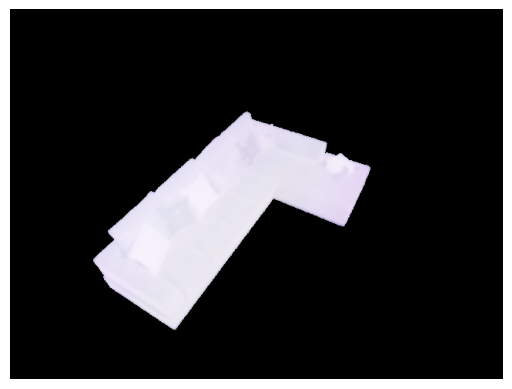

In [153]:
# Process tensor for visualization
im = image_shading.detach().cpu().squeeze(0).permute(1, 2, 0)  # Convert to [480, 640, 3]

# Assuming tensor values are in [-1, 1], normalize to [0, 1]
# If your image data is already in [0, 1], you can skip this step

# Display image
plt.imshow(im)
plt.axis('off')  # Hide axis
plt.show()

In [154]:
albedo_dataset = AlbedoDataset(image=images, albedo=albedos)
t = PreTrain(albedo_dataset, 'C:\\Users\\lucien\\Github\\CGVI-Project\\results\\albedo_pretrain', 50)

In [155]:
t.load_checkpoint(albedo_path)

50

In [156]:
image_albedo = t.generate(torch.from_numpy(image).unsqueeze(0)).detach()
torch_albedo_gt = torch.from_numpy(albedo_gt).unsqueeze(0).type(torch.cuda.FloatTensor)
l2_loss = nn.MSELoss()
mask = (torch.from_numpy(image).unsqueeze(0) > 0.01).type(torch.cuda.FloatTensor)
frac = 640*480*3/torch.sum(mask)
print(l2_loss(image_albedo * mask, torch_albedo_gt * mask).item() * frac)
print(frac)

tensor(0.0069, device='cuda:0')
tensor(6.9316, device='cuda:0')


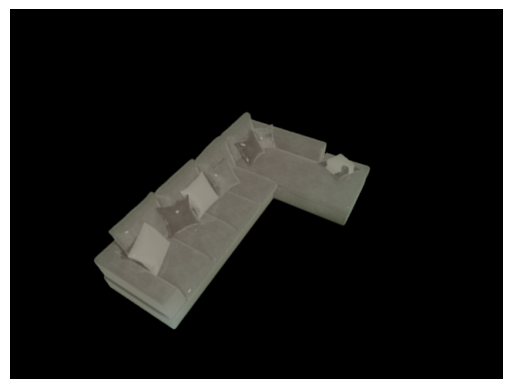

In [157]:
# Process tensor for visualization
im = image_albedo.detach().cpu().squeeze(0).permute(1, 2, 0)  # Convert to [480, 640, 3]

# Assuming tensor values are in [-1, 1], normalize to [0, 1]
# If your image data is already in [0, 1], you can skip this step

# Display image
plt.imshow(im)
plt.axis('off')  # Hide axis
plt.show()

In [147]:
shape_shading_mse = []
shape_albedo_mse = []
shape_image_mse = []
import random
rdinx = random.sample(range(len(shape_intrinsic_dataset)), 20)
for idx in rdinx:
    image, albedo_gt, shading_gt = shape_intrinsic_dataset[idx]


    image_shading = s.generate(torch.from_numpy(image).unsqueeze(0)).detach()
    torch_shading_gt = torch.from_numpy(shading_gt).unsqueeze(0).type(torch.cuda.FloatTensor)
    image_albedo = t.generate(torch.from_numpy(image).unsqueeze(0)).detach()
    torch_albedo_gt = torch.from_numpy(albedo_gt).unsqueeze(0).type(torch.cuda.FloatTensor)


    intrinsic = Intrinsic(image, save_path, image_albedo, image_shading, albedo_gt, shading_gt, 500)

    intrinsic.optimize()

    shape_shading_mse.append(np.min(intrinsic.shading_losses))
    shape_albedo_mse.append(np.min(intrinsic.albedo_losses))
    shape_image_mse.append(np.min(intrinsic.image_losses))

In [148]:
print(np.mean(shape_albedo_mse))
print(np.mean(shape_image_mse))
print(np.mean(shape_shading_mse))

0.0032128054
0.043456726
0.008628125


In [178]:
print(len(testind))

330


In [96]:
shading_imp = []
albedo_imp = []
image_imp = []

In [103]:

for idx in testind[5:15]:
    image, albedo_gt, shading_gt = intrinsic_dataset[idx]

    l2_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    mask = (torch.from_numpy(image).unsqueeze(0) > 0.01).type(torch.cuda.FloatTensor)
    frac = 640*480*3/torch.sum(mask)

    image_shading = s.generate(torch.from_numpy(image).unsqueeze(0)).detach()
    torch_shading_gt = torch.from_numpy(shading_gt).unsqueeze(0).type(torch.cuda.FloatTensor)
    image_albedo = t.generate(torch.from_numpy(image).unsqueeze(0)).detach()
    torch_albedo_gt = torch.from_numpy(albedo_gt).unsqueeze(0).type(torch.cuda.FloatTensor)

    pre_shading_loss = (l1_loss(image_shading * mask, torch_shading_gt * mask).item() * frac).cpu().numpy()
    pre_albedo_loss = (l2_loss(image_albedo * mask, torch_albedo_gt * mask).item() * frac).cpu().numpy()
    pre_image_loss = (l2_loss(image_shading * image_albedo * mask, torch.from_numpy(image).unsqueeze(0).type(torch.cuda.FloatTensor) * mask).item() * frac).cpu().numpy()
    print(pre_shading_loss, pre_albedo_loss, pre_image_loss, frac)

    intrinsic = Intrinsic(image, save_path, image_albedo, image_shading, albedo_gt, shading_gt, 500)

    intrinsic.optimize()

    image_imp.append((pre_image_loss - np.min(intrinsic.image_losses)) / pre_image_loss)
    shading_imp.append((pre_shading_loss - np.min(intrinsic.shading_losses)) / pre_shading_loss)
    albedo_imp.append((pre_albedo_loss - np.min(intrinsic.albedo_losses)) / pre_albedo_loss)

0.045556344 0.051881086 0.1419144 tensor(9.6395, device='cuda:0')
0.02142099 0.009035468 0.11588417 tensor(5.7872, device='cuda:0')oss 0.057349 Loss 0.085737 frac 9.63946  
0.059090383 0.01362889 0.069813974 tensor(18.9229, device='cuda:0')s 0.050491 Loss 0.093690 frac 5.78716  
0.13783923 0.0046181427 0.043039404 tensor(4.6818, device='cuda:0')s 0.018879 Loss 0.071701 frac 18.92286  
0.018580748 0.0039440147 0.111528814 tensor(3.1757, device='cuda:0') 0.009597 Loss 0.089135 frac 4.68179  
0.050554547 0.04423055 0.12317074 tensor(4.6455, device='cuda:0')oss 0.052439 Loss 0.109006 frac 3.17569  
0.030109951 0.050484266 0.16165037 tensor(14.0025, device='cuda:0')s 0.040364 Loss 0.104497 frac 4.64547  
0.041148126 0.0458968 0.14181045 tensor(8.5348, device='cuda:0')Loss 0.046765 Loss 0.081961 frac 14.00246  
0.04806803 0.009305137 0.06673893 tensor(3.8673, device='cuda:0')oss 0.056534 Loss 0.088106 frac 8.53476  
0.050637696 0.03149152 0.12249714 tensor(16.6721, device='cuda:0')ss 0.02185

In [161]:
intrinsic = Intrinsic(image, save_path, image_albedo, image_shading, albedo_gt, shading_gt, 1000)

In [105]:
print(shading_imp)
print(albedo_imp)
print(image_imp)

[-0.52400166, -0.8299162, 0.18253867, 0.19344646, -0.78466946, -1.0575577, -0.15510279, -0.16947402, -0.7544914, -0.29103395]
[0.9350513, 0.89251083, 0.6595823, -3.0863888, 0.8074605, 0.90091246, 0.9467402, 0.90285826, 0.50765836, 0.81771904]
[0.80662817, 0.71094507, 0.8403018, 0.8226529, 0.6926654, 0.68227977, 0.8091989, 0.71449775, 0.68151176, 0.9011018]


In [ ]:
[-0.42545226, -3.876209, -4.135683, -0.9123726, -1.1323715, -2.247173, -2.5948305, 0.38730866, 0.6346567, -1.6060026]
[0.5709166, 0.8591654, 0.87504613, 0.6850252, 0.7440064, 0.93600464, 0.8623997, 0.630364, -3.614545, 0.7977075]
[0.6776322, 0.39505774, 0.35491824, 0.674256, 0.7845643, 0.5101422, 0.602826, 0.67944705, 0.79225016, 0.25607216]

In [104]:
print(np.mean(shading_imp))
print(np.mean(albedo_imp))
print(np.mean(image_imp))

-0.4190262
0.42841044
0.7661783


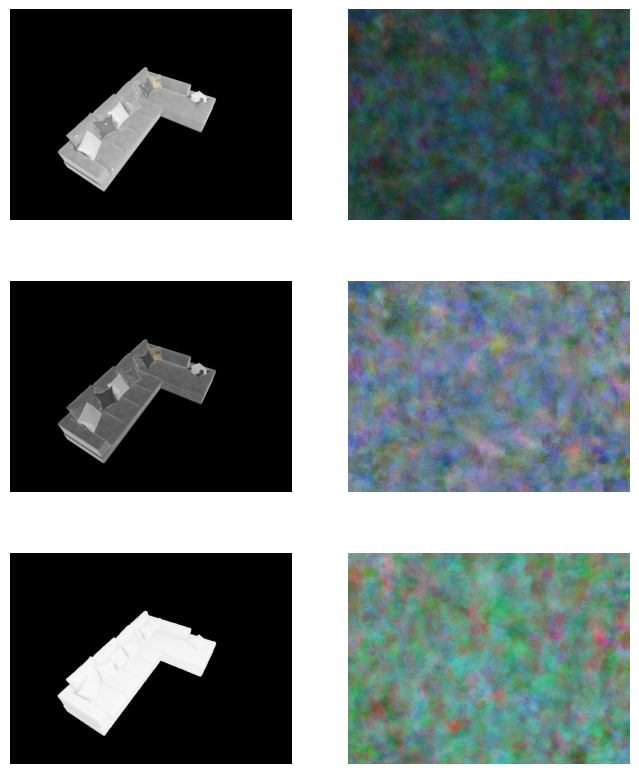

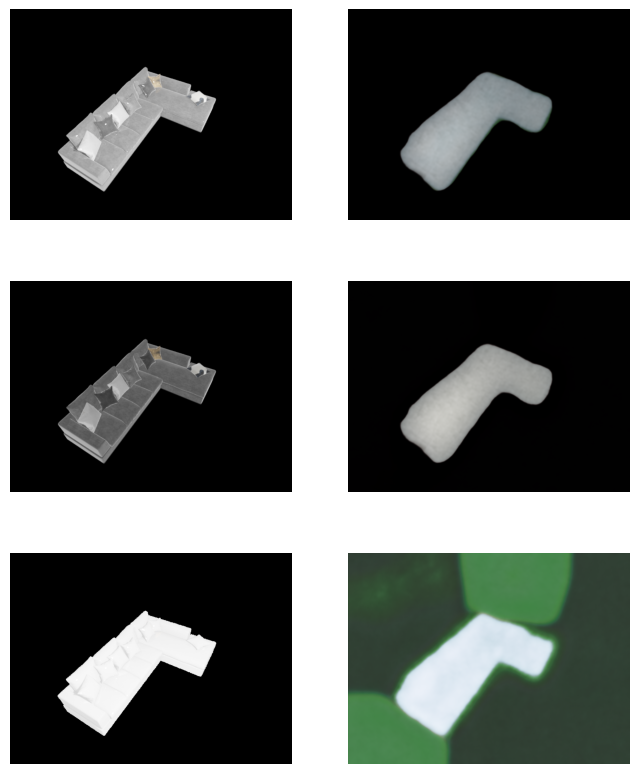

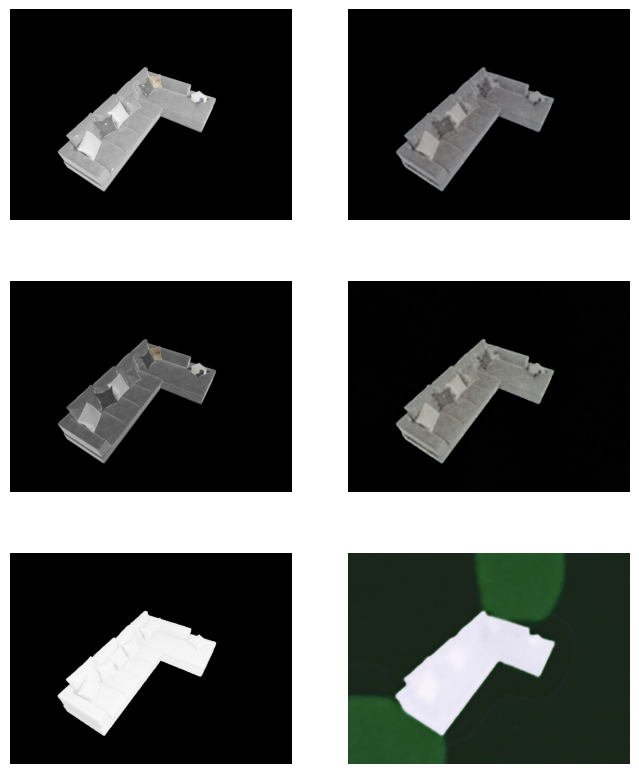

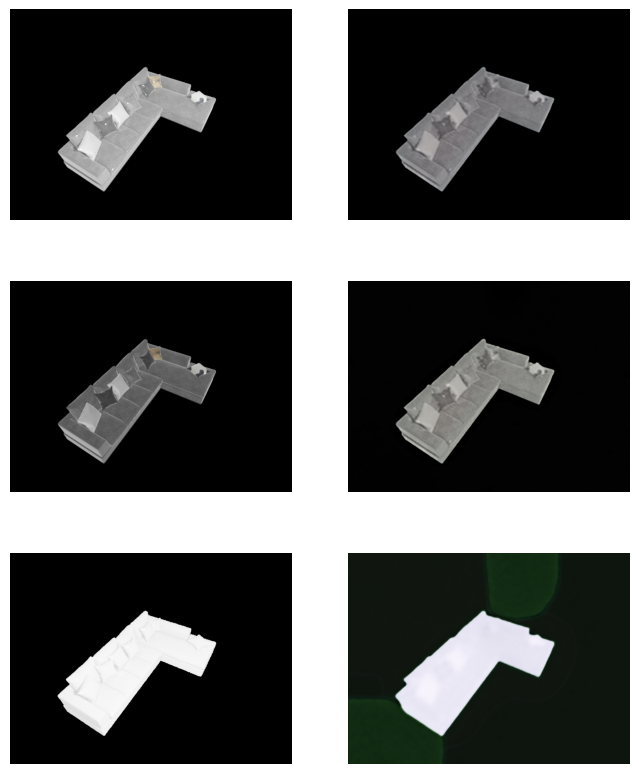

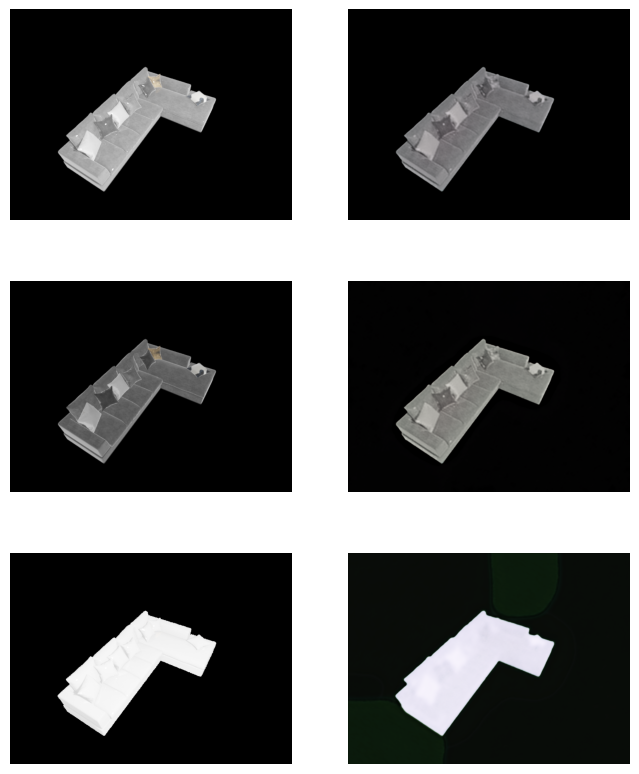

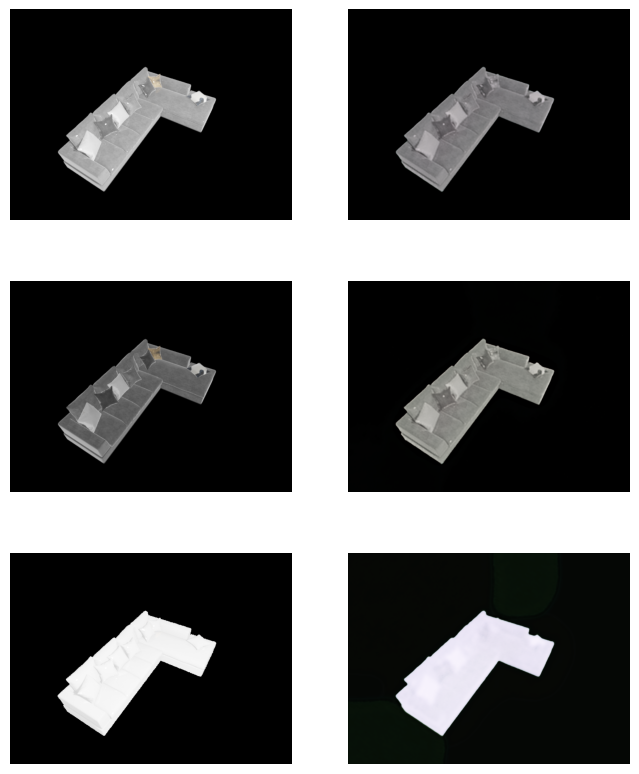

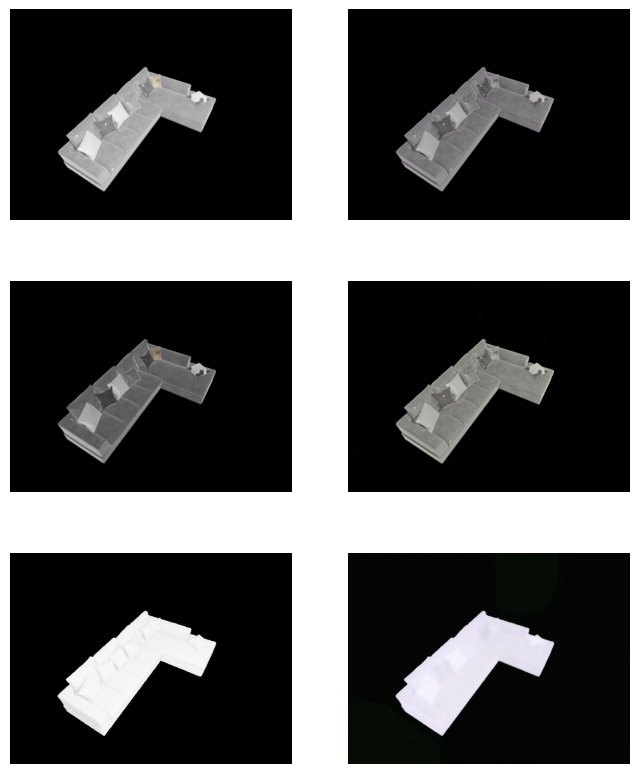

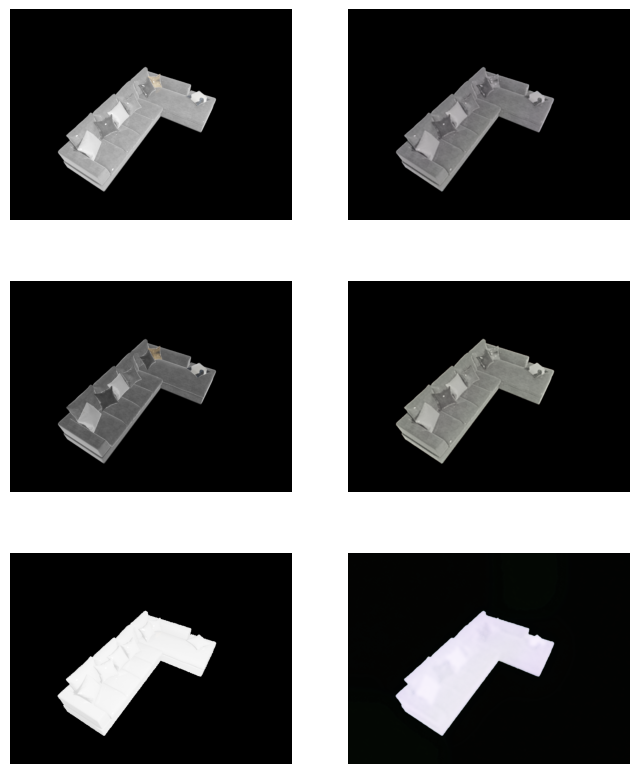

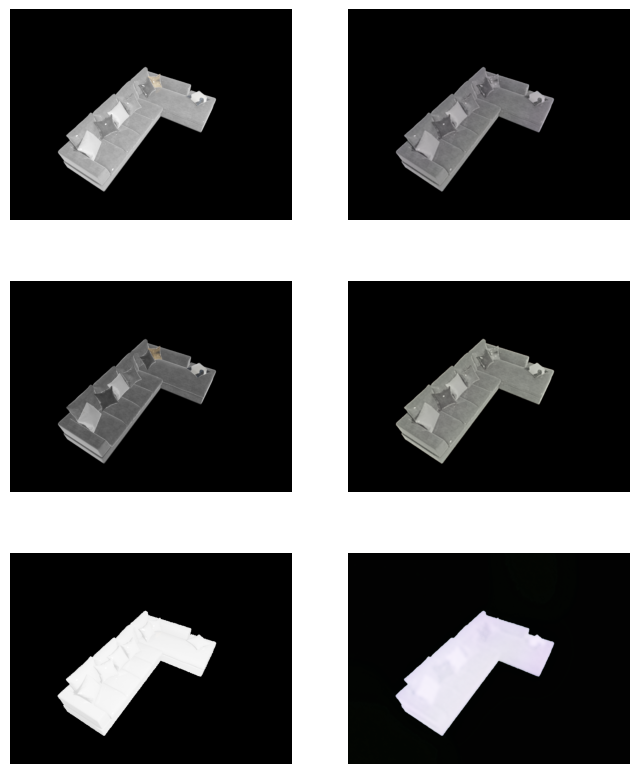

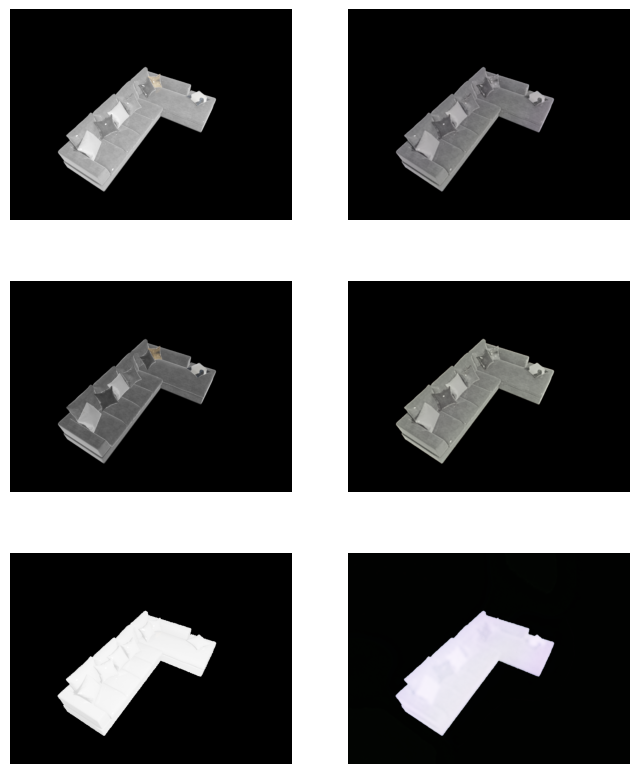

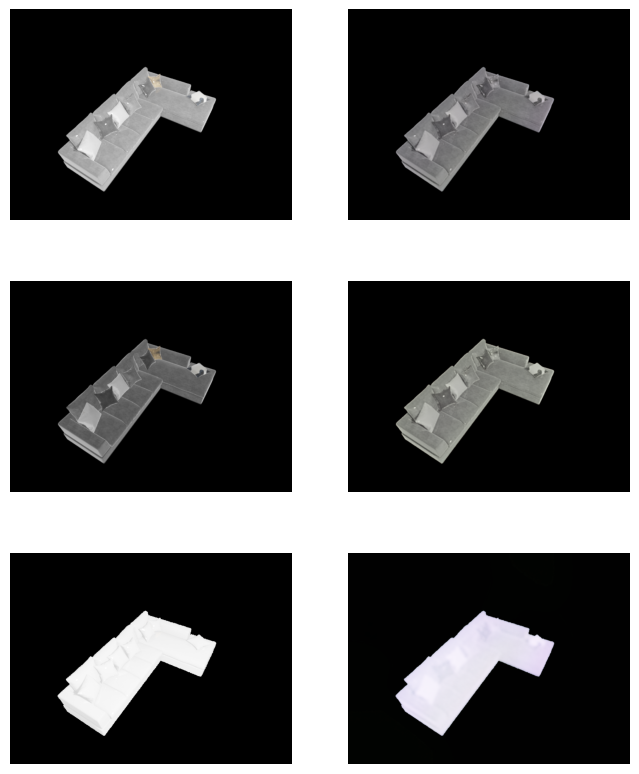

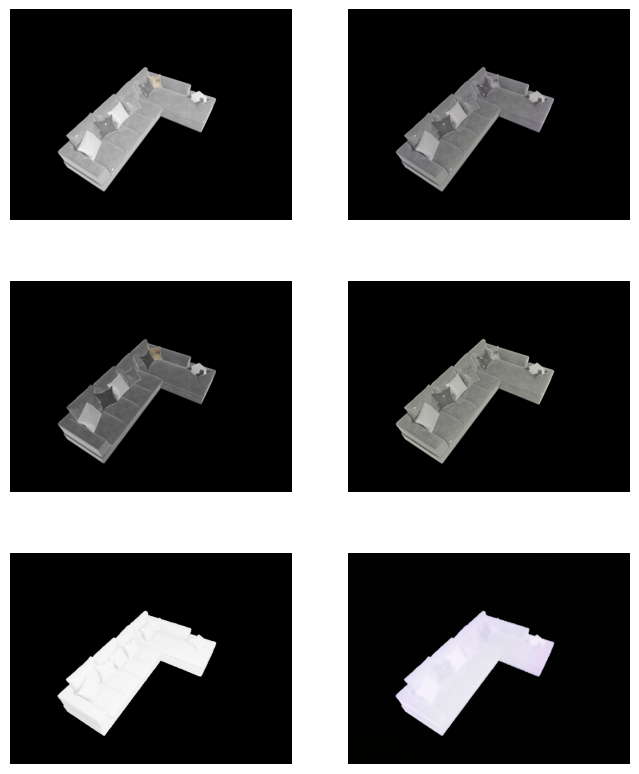

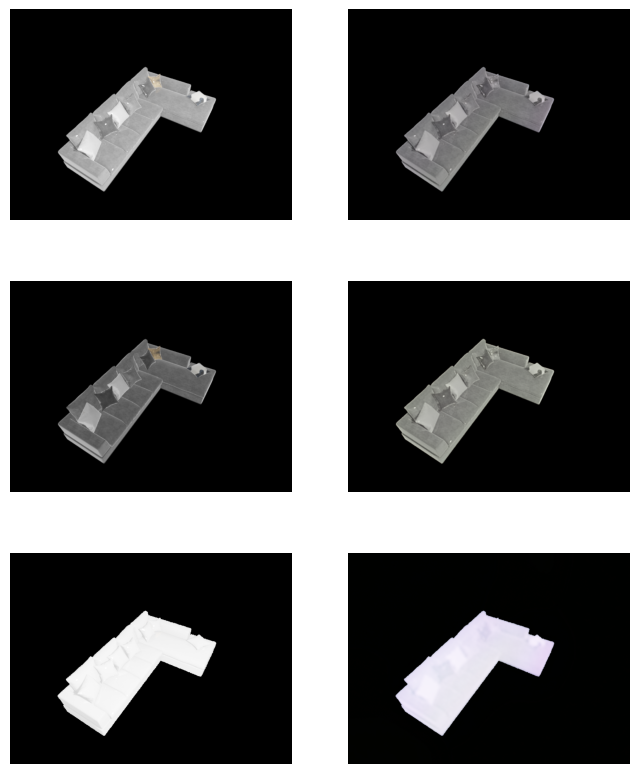

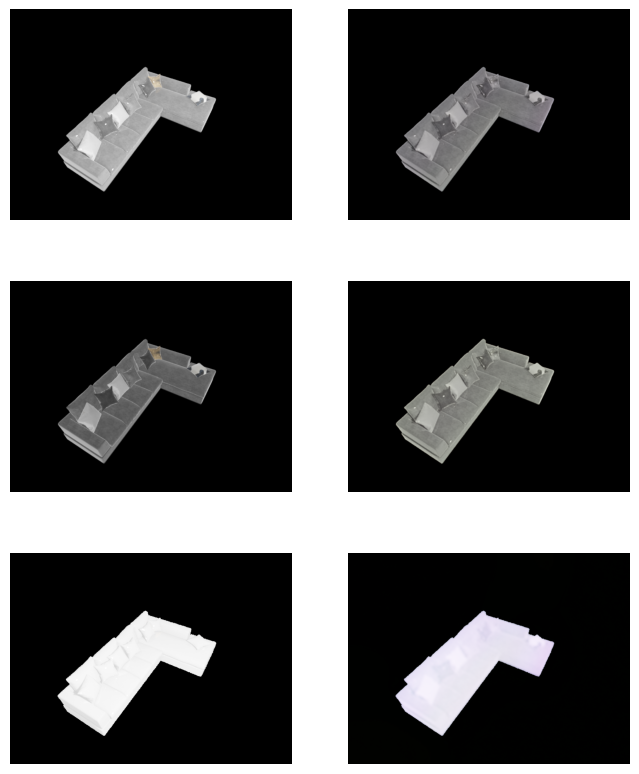

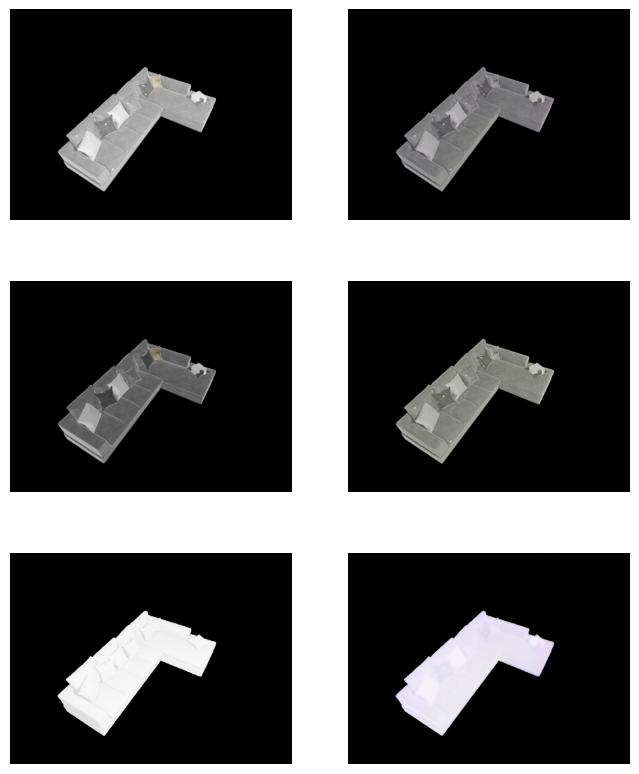

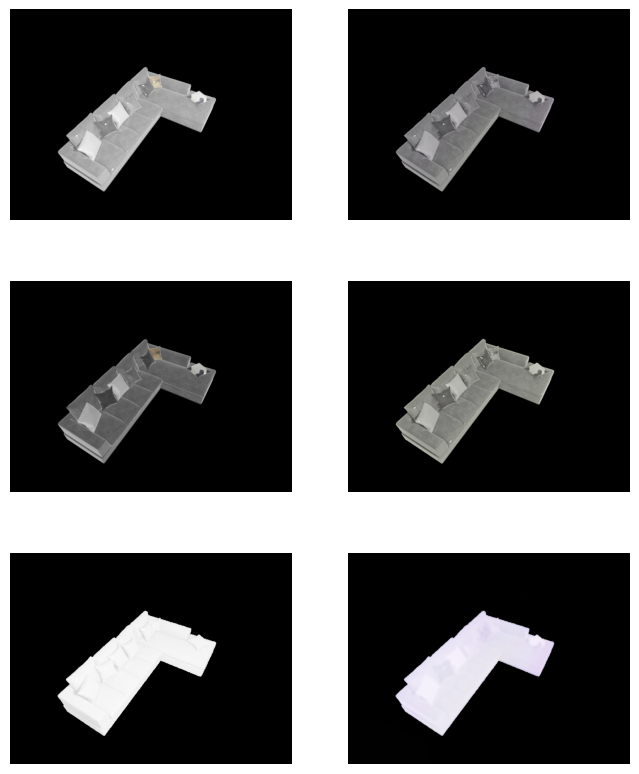

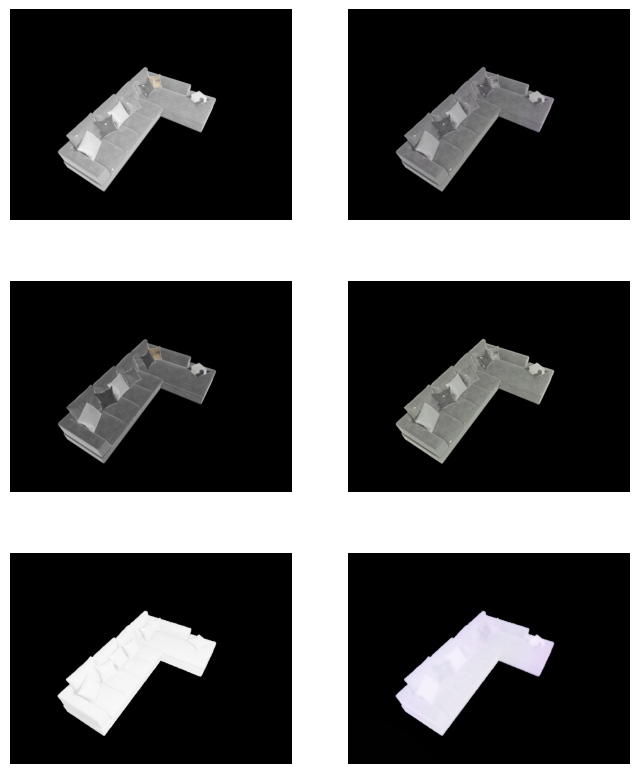

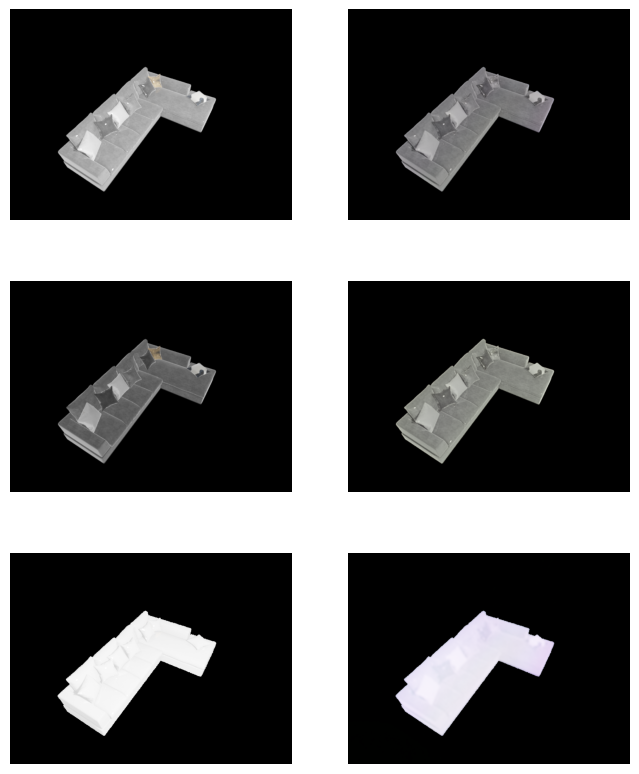

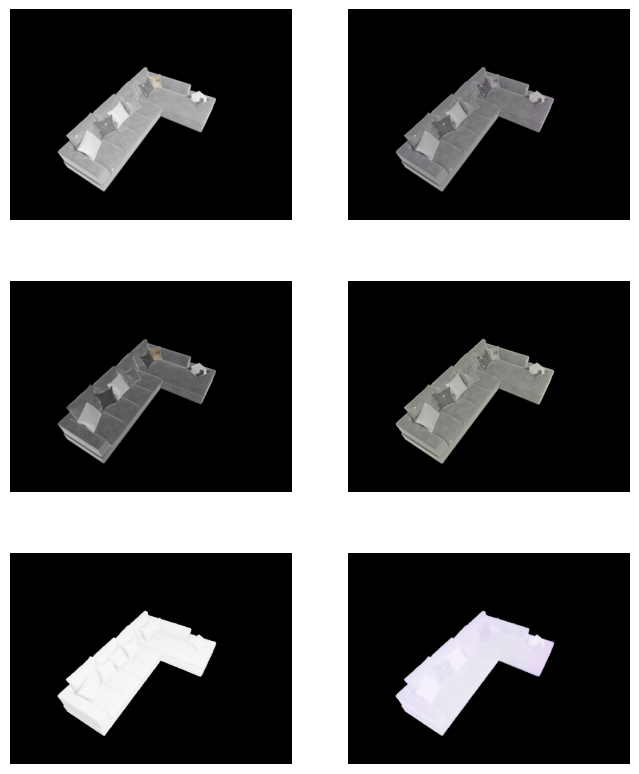

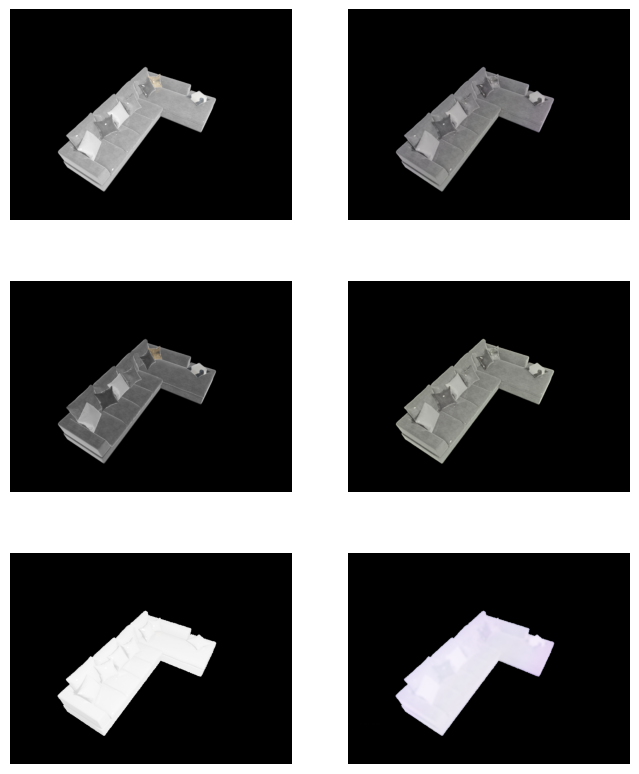

In [162]:
intrinsic.optimize()

In [126]:
print(np.min(intrinsic.image_losses))
print(np.min(intrinsic.albedo_losses))
print(np.min(intrinsic.shading_losses))

0.015644751
0.0056383
0.083186306


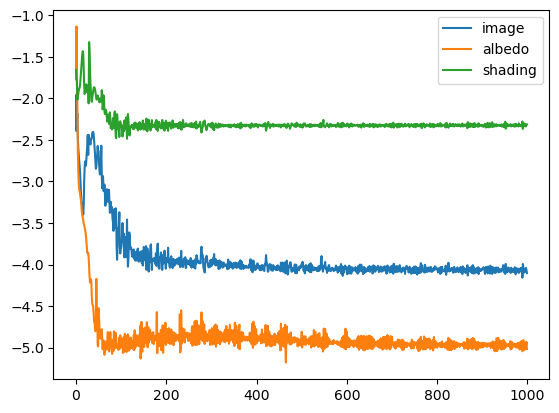

In [127]:
intl = 1
tx = range(0, 1000)[::intl]
plt.plot(tx, np.log(intrinsic.image_losses[::intl]), label='image')
plt.plot(tx, np.log(intrinsic.albedo_losses[::intl]), label='albedo')
plt.plot(tx, np.log(intrinsic.shading_losses[::intl]), label='shading')
plt.legend()
plt.show()